In [1]:
import matplotlib
matplotlib.rcParams['font.size'] = 24
matplotlib.rcParams.update({
    "font.family": "serif",
})
import matplotlib.pyplot as plt

In [2]:
import glob
import numpy as np
import pandas as pd

from pymatgen.analysis.phase_diagram import PDEntry, PhaseDiagram
from pymatgen.core import Composition, Element, Structure
from pymatgen.io.lammps.data import LammpsData
from pymatgen.analysis.diffusion_analyzer import get_conversion_factor
from pymatgen.io.lammps.outputs import parse_lammps_log
import scipy.constants as const

/opt/conda/lib/python3.9/site-packages/pymatgen/analysis/diffusion_analyzer.py:44: FutureWarning: All code in pymatgen.analysis.diffusion_analyzer has been moved to the separate add-on packagepymatgen-diffusion, which also includes a lot more functionality for analyzing diffusioncalculations. This module here is retained for backwards compatibility. It will be removed from2022.1.1.
  warnings.warn(


In [3]:
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns

In [4]:
t_steps = np.linspace(0, 10**3, 5001)

In [5]:
def fit_msd(data):
    start = 100
    end = 1000
    n = data.shape[0]
    k, b = np.polyfit(np.linspace(0, 0.2*(n-1), n)[start:end], data[start:end], 1)
    return k, b

## time

In [6]:
path_msd = glob.glob('LiSiPS/time/*/*/msd.npy')

In [7]:
rawtime = pd.DataFrame([{'temperature': int(path.split('/')[2]),
                    'n_sample': path.split('/')[3],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [8]:
rows = []
for temp, part in rawtime.groupby('temperature'):
    rows.append({
        'temperature': temp,
        'D': part['diffusivity'].values.mean(),
        'D_std': part['diffusivity'].values.std(),
    })
time = pd.DataFrame(rows)

In [9]:
path_msd = glob.glob('LiSiPS/time/*/*/msd-*.npy')

In [10]:
rawtimesplit = pd.DataFrame([{'temperature': int(path.split('/')[2]),
                    'n_sample': path.split('/')[3],
                    'time': int(path.split('/')[-1].split('-')[1][:-4]), 
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [11]:
rows = []
for temp, part in rawtimesplit.groupby('temperature'):
    for ctime, subpart in part.groupby('time'):
        rows.append({
            'temperature': temp,
            'D': subpart['diffusivity'].values.mean(),
            'D_std': subpart['diffusivity'].values.std(),
            'time': ctime, 
        })
splittime = pd.DataFrame(rows)

In [12]:
stc = Structure.from_file('LiSiPS/cifs/LiSiPS_exp300K.cif')

get_conversion_factor(stc, 'Li', 300) * time['D'].values[0] * 10**-4

/opt/conda/lib/python3.9/site-packages/pymatgen/io/cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


14.03208271901841

In [13]:
get_conversion_factor(stc, 'Li', 300) * time['D_std'].values[0] * 10**-4

1.0010393215788875

In [14]:
time

,temperature,D,D_std
0,300,0.001060,0.000076
1,400,0.004373,0.000253
2,500,0.025772,0.000382
3,666,0.112892,0.000756


Text(0, 0.5, 'MSD($\\AA^2$)')

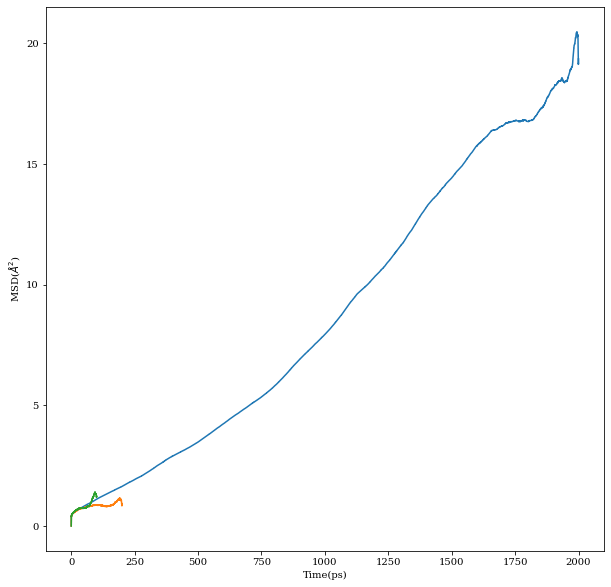

In [15]:
fig, ax = plt.subplots(figsize=[10, 10])
for p in path_msd[-3:]:
    data = np.sum(np.load(p), axis=1)
    n = data.shape[0]
    ax.plot(np.linspace(0, 0.2*(n-1), n), data)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Time(ps)')
ax.set_ylabel('MSD($\AA^2$)')

## disorder

In [16]:
path_msd = glob.glob('LiSiPS/disorder/*/*/msd.npy')

In [17]:
rawdisorder = pd.DataFrame([{'temperature': int(path.split('/')[2]),
                    'n_sample': path.split('/')[3],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [18]:
rows = []
for temp, part in rawdisorder.groupby('temperature'):
    rows.append({
        'temperature': temp,
        'D': part['diffusivity'].values.mean(),
        'D_std': part['diffusivity'].values.std(),
    })
disorder = pd.DataFrame(rows)

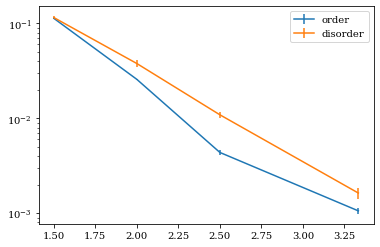

In [19]:
plt.errorbar(1000/time['temperature'], time['D'], time['D_std'], label='order')
plt.errorbar(1000/disorder['temperature'], disorder['D'], disorder['D_std'], label='disorder')
plt.yscale('log')
plt.legend()

## size

In [20]:
path_msd = glob.glob('LiSiPS/size/*/*/msd.npy')

In [21]:
rawsize = pd.DataFrame([{
                    'temperature': int(path.split('/')[2].split('-')[0]),
                    'n_sample': path.split('/')[3],
                    'size': path.split('/')[2].split('-')[1],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [22]:
rows = []
for temp, part in rawsize.groupby('temperature'):
    for s, ppart in part.groupby('size'):
        rows.append({
            'temperature': temp,
            'size': s, 
            'natoms': 50*np.prod([int(i) for i in s]),
            'D': ppart['diffusivity'].values.mean(),
            'D_std': ppart['diffusivity'].values.std(),
        })
size = pd.DataFrame(rows)

In [23]:
size

,temperature,size,natoms,D,D_std
0,300,111,50,0.005349,0.000952
1,300,221,200,0.003636,0.000285
2,300,222,400,0.003041,0.001007
3,300,442,1600,0.000459,0.000037
4,400,111,50,0.025653,0.001162
5,400,221,200,0.018743,0.000027
6,400,222,400,0.003747,0.001475
7,400,442,1600,0.001447,0.000169
8,500,111,50,0.059411,0.006848
9,500,221,200,0.056322,0.002408


In [24]:
size332 = time.copy()

In [25]:
size332['size'] = '332'
size332['natoms'] = 50* 18

In [26]:
size = size.append(size332)

In [27]:
size = size.sort_values('natoms')

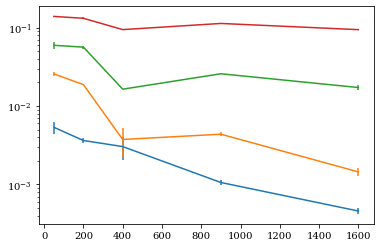

In [28]:
for temp, s in size.groupby('temperature'):
    plt.errorbar(s['natoms'], s['D'], s['D_std'])
plt.yscale('log')

In [29]:
size442 = size[size['natoms'] == 1600]

In [30]:
fmts = ['^', 'd', 'o', 's', 'v']

([<matplotlib.axis.XTick at 0x7fb8ab6d5400>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

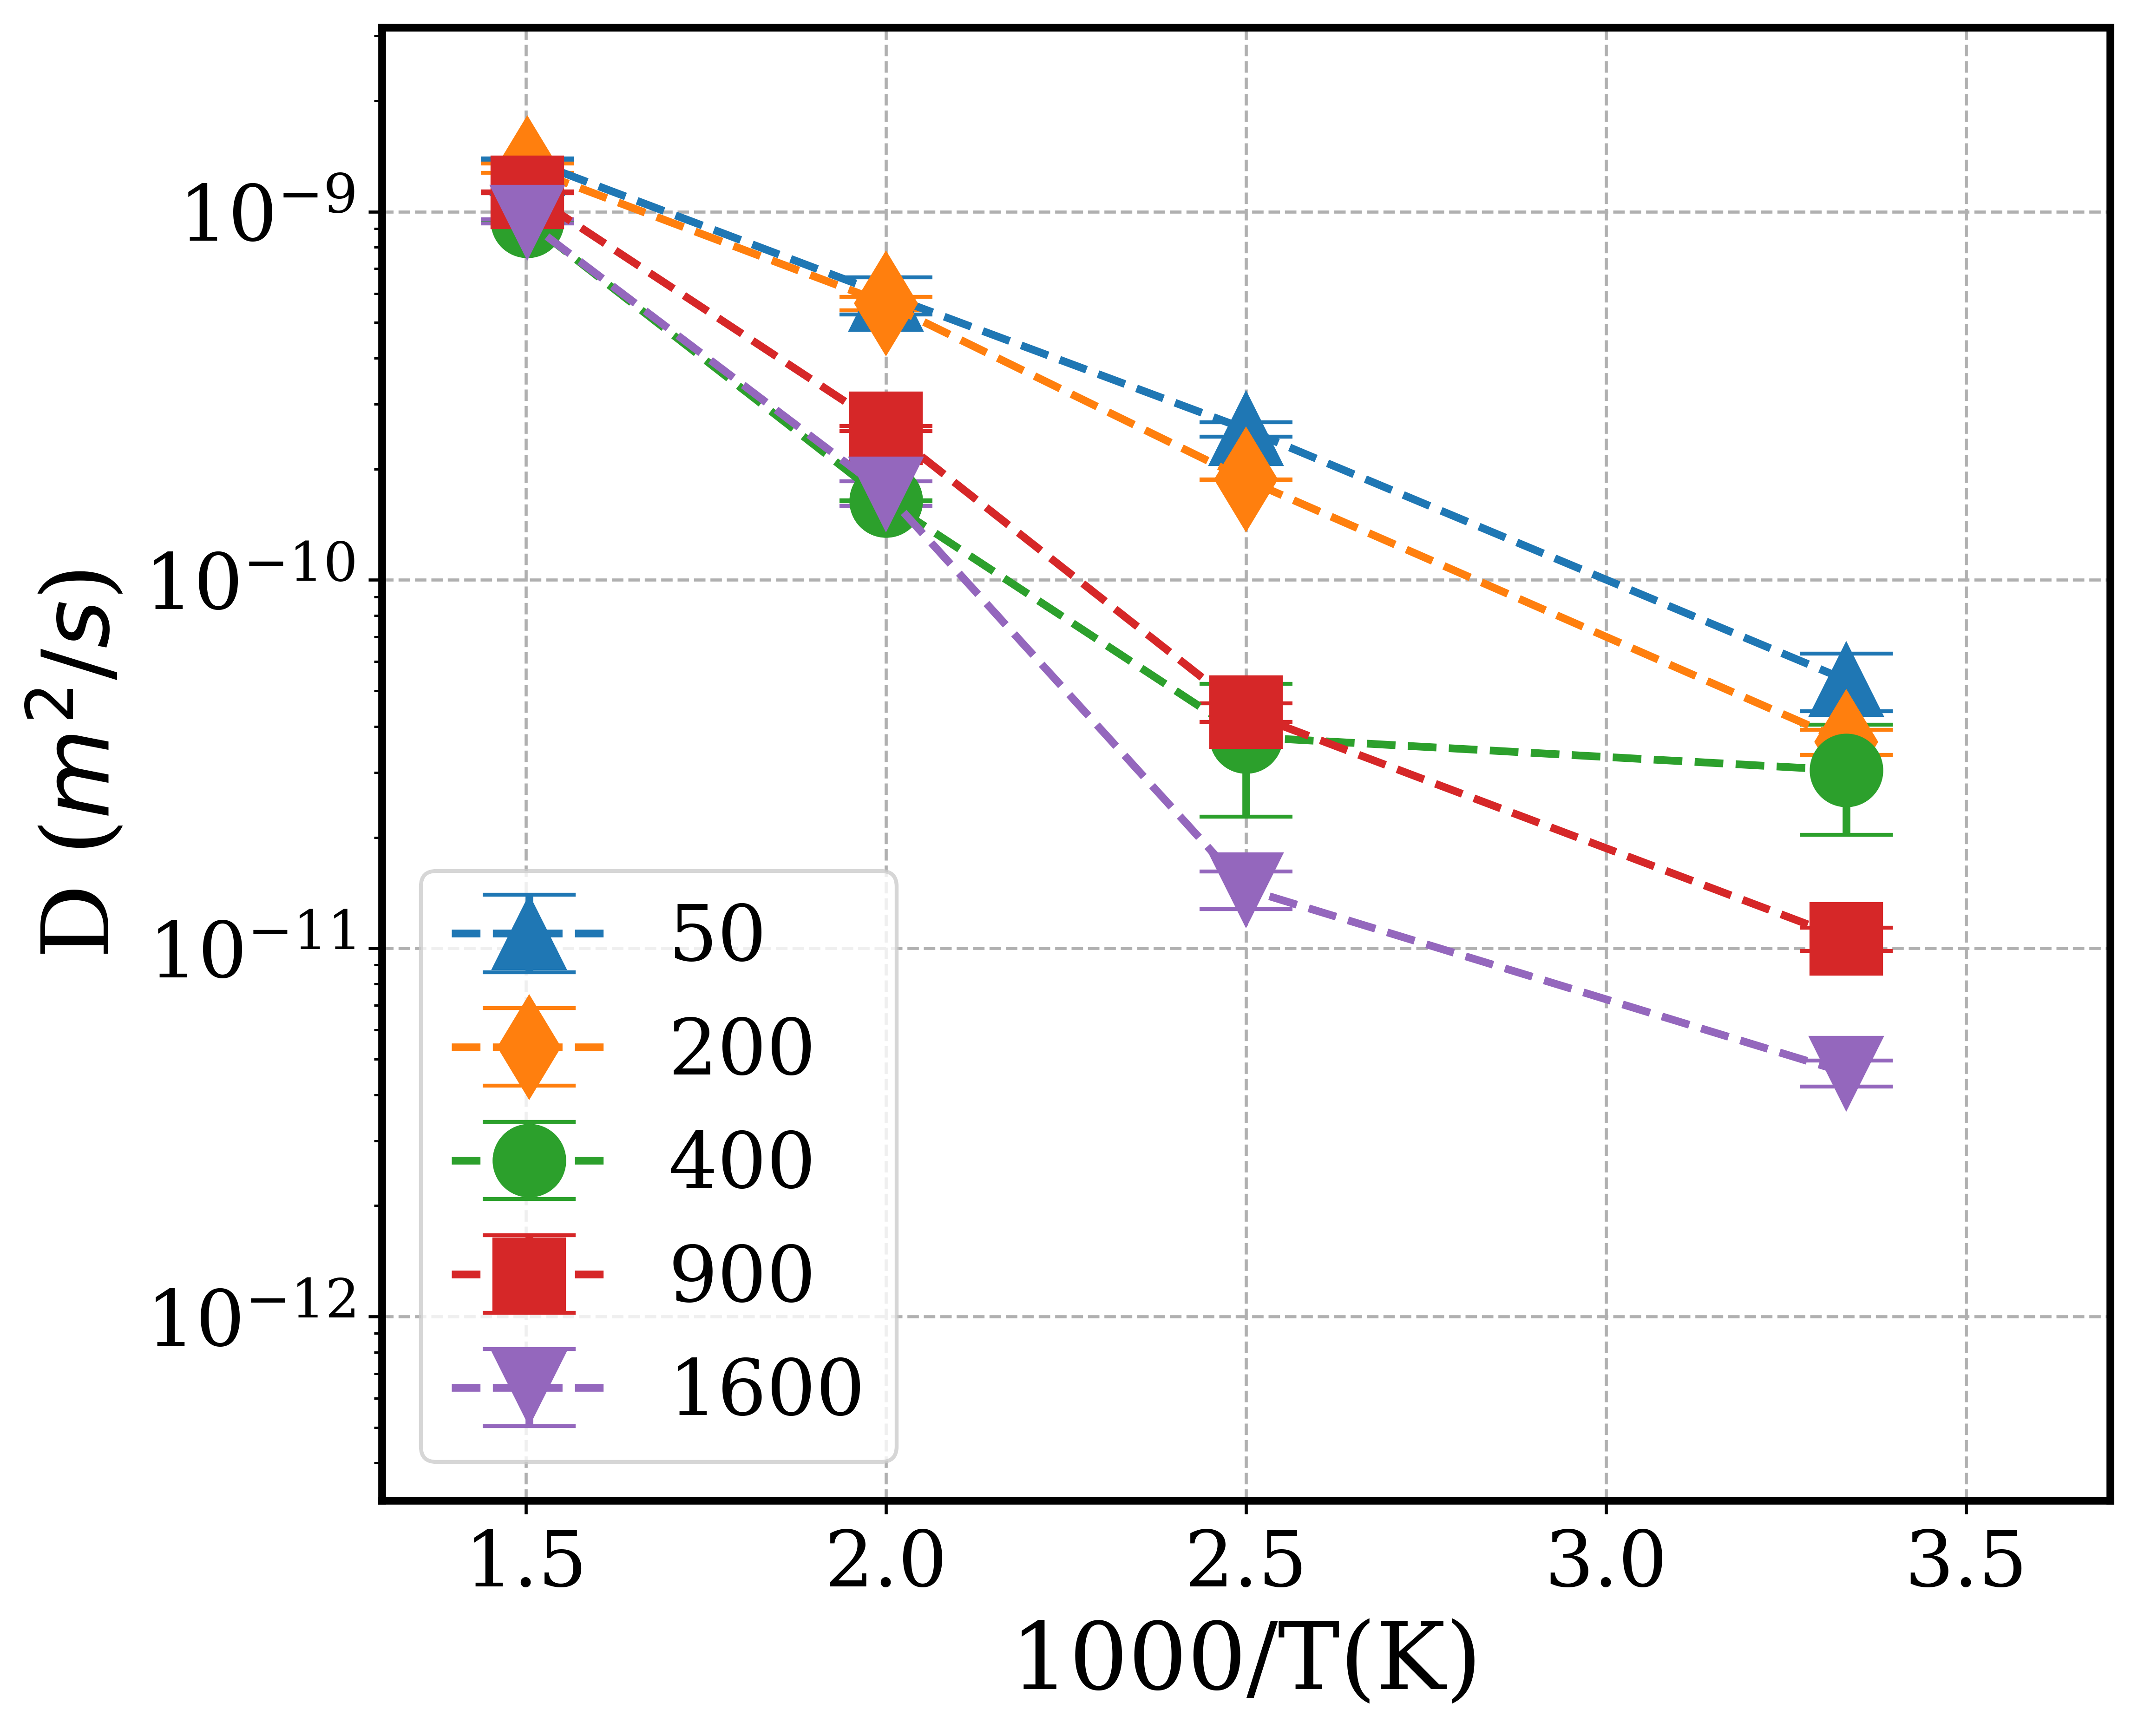

In [31]:
fig = plt.figure(figsize=[8, 7], dpi=600)

ax = fig.gca()
ax.spines["bottom"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

for i, [sz, part] in enumerate(size.groupby('natoms')):
    part = part.sort_values('temperature')
    ax.errorbar(1000/part['temperature'], part['D']*10**-8, 
                part['D_std']*10**-8, label=sz, 
                capsize=12, fmt=fmts[i], markersize=18, linestyle='--', linewidth=2)

plt.legend(loc=3, fontsize=20)
    
plt.yscale('log')

plt.ylim(10**(-12.5), 10**(-8.5),)
plt.xlim(1.3, 3.7)
plt.grid(linestyle='dashed')
plt.xlabel('1000/T(K)', fontsize=24)
plt.ylabel('D ($m^2/s$)', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks([1.5, 2, 2.5, 3, 3.5], fontsize=20)

## time and size

In [32]:
splittime10000 = time.copy()

In [33]:
splittime10000['time'] = 10000

In [34]:
splittime = pd.concat([splittime10000, splittime])

In [35]:
splittime = splittime.sort_values('temperature')

In [36]:
part['D'].values/part['D'].values[-1]

array([0.00487673, 0.01538051, 0.18292339, 1.        ])

(array([1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

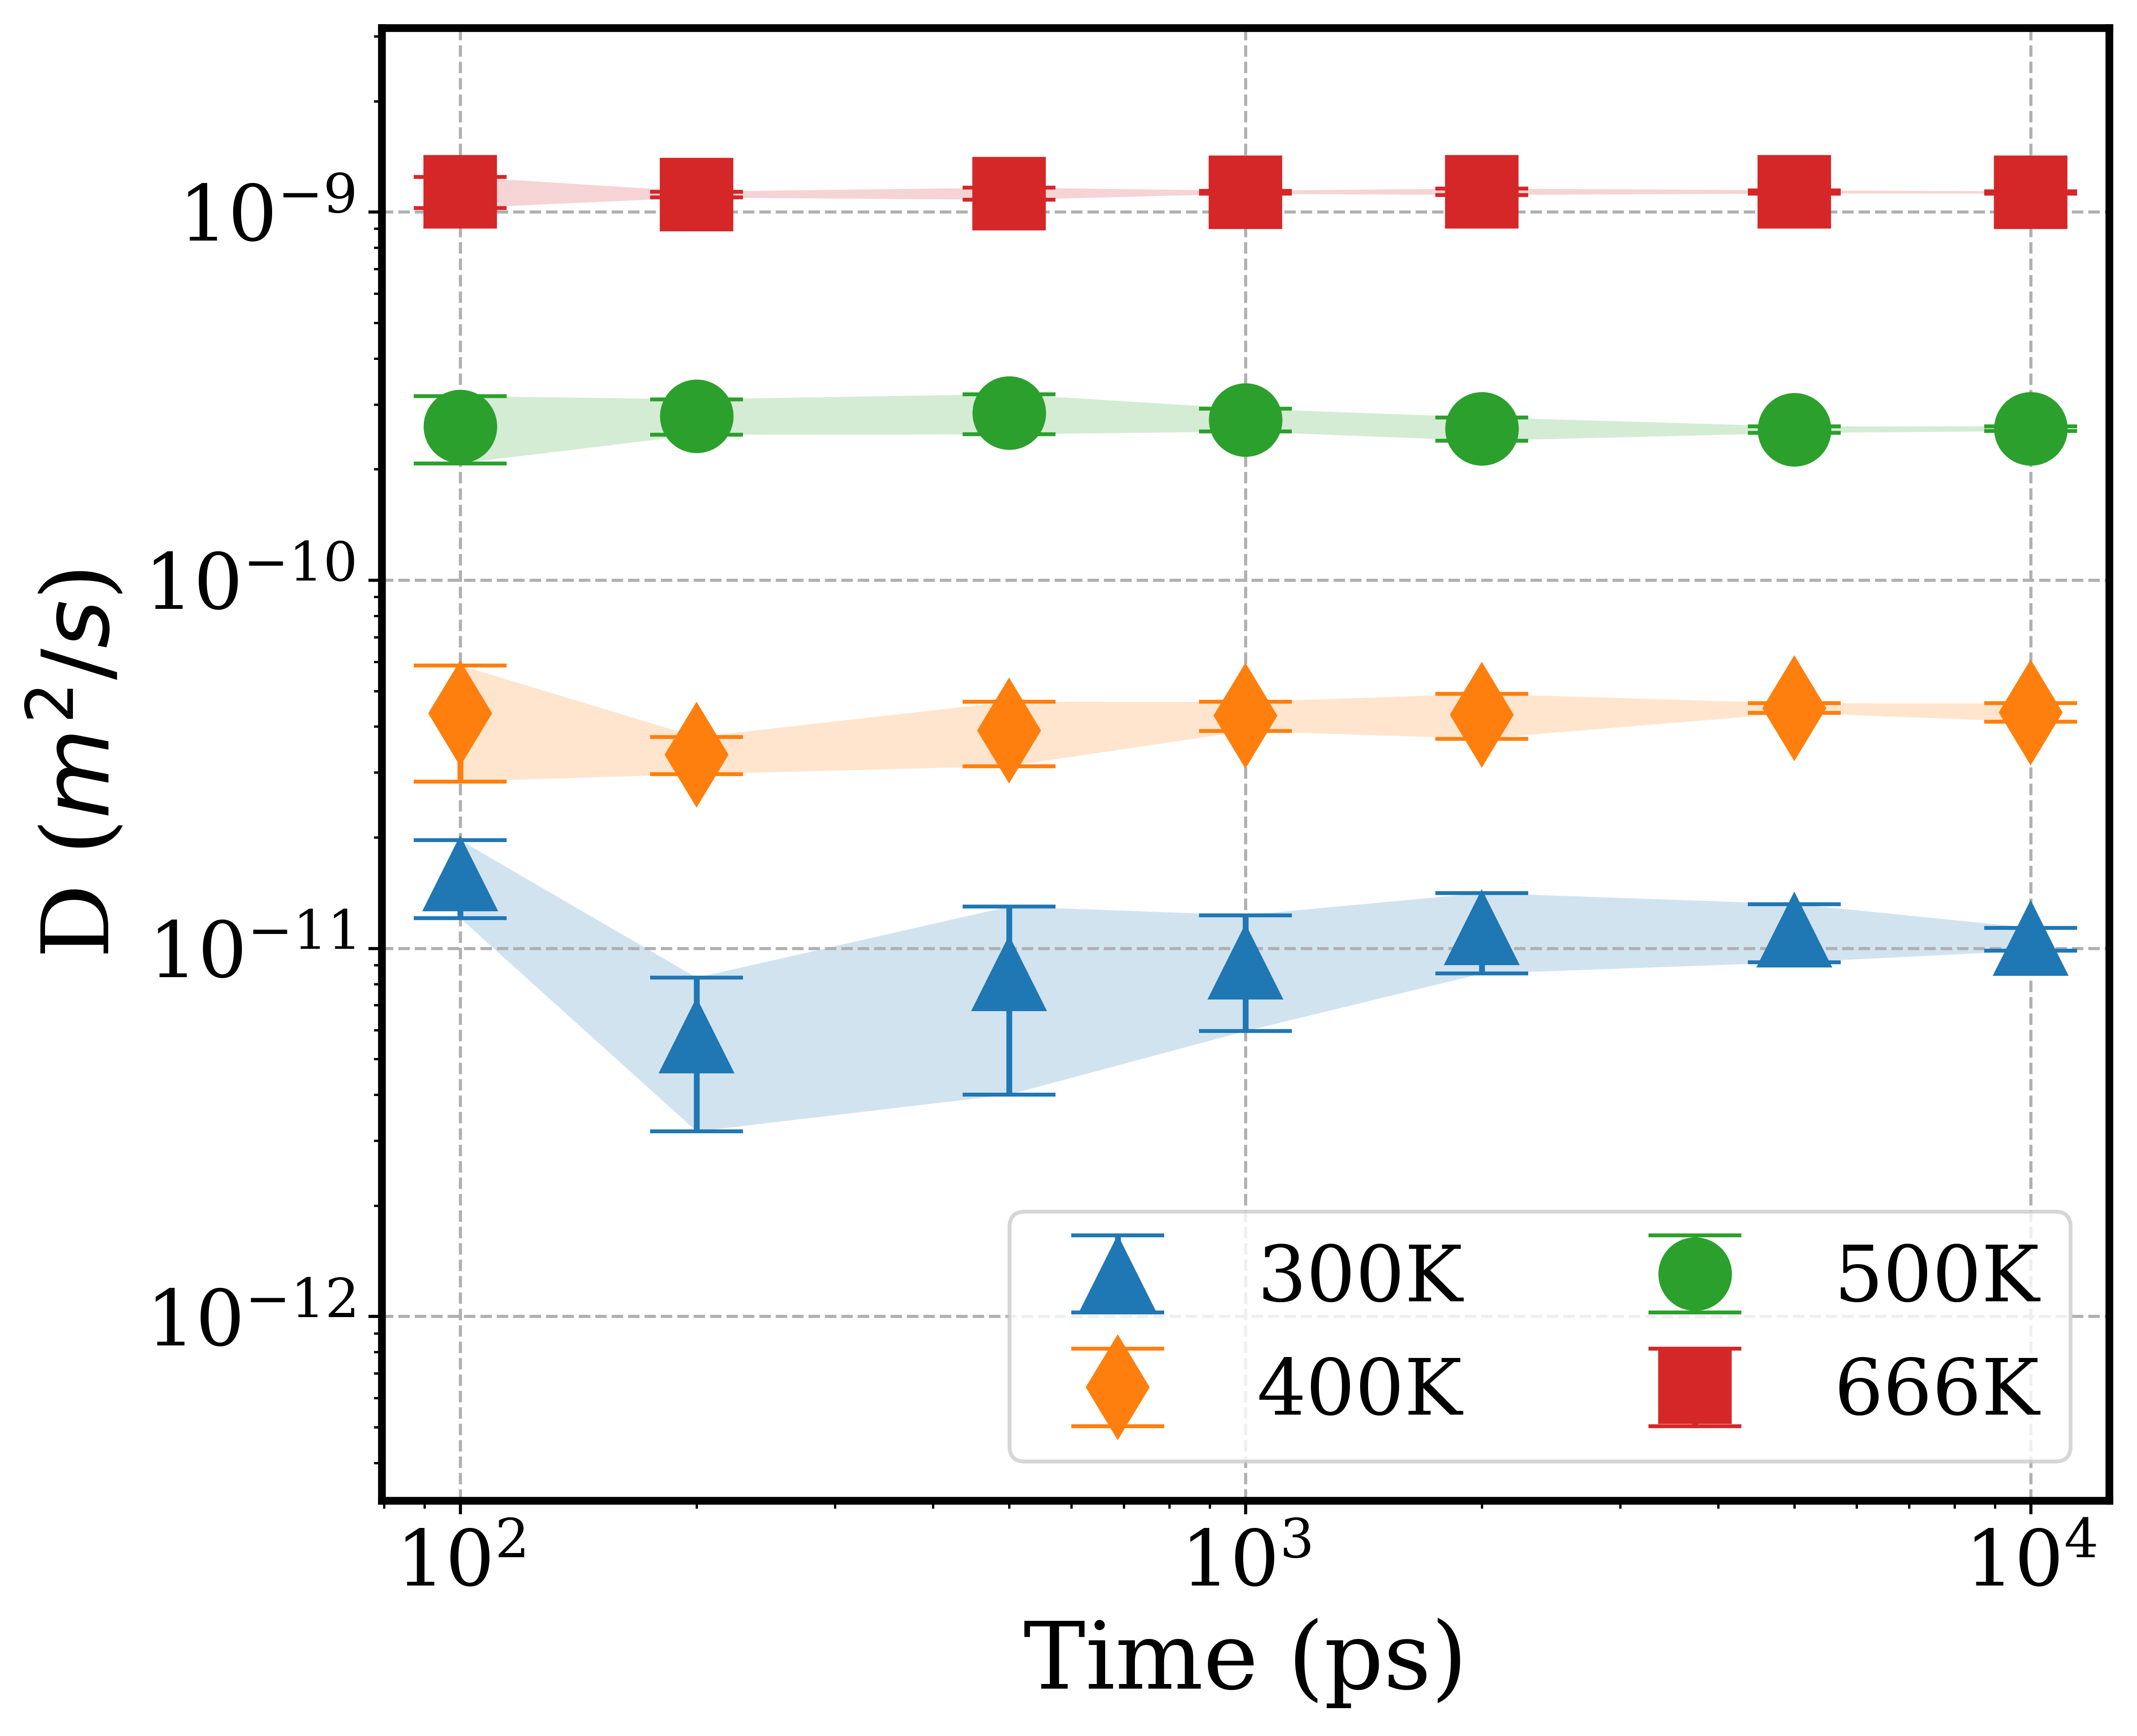

In [37]:
fig = plt.figure(figsize=[8, 7], dpi=600)

ax = fig.gca()
ax.spines["bottom"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

plt.xscale('log')
plt.yscale('log')
for i, [temp, part] in enumerate(splittime.groupby('temperature')):
#    for time, subpart in part.groupby('time'):
    part = part.sort_values('time')
    ax.errorbar(part['time'], part['D']*10**-8, 
                part['D_std']*10**-8, label=str(temp)+'K', 
                capsize=12, fmt=fmts[i], markersize=18)
#    ax.scatter(part['time'], part['D'])
    ax.fill_between(part['time'], 
                    (part['D']-part['D_std'])*10**-8, (part['D']+part['D_std'])*10**-8, alpha=0.2)
    
plt.legend(fontsize=20, ncol=2, loc=4)
plt.ylim(10**(-12.5), 10**(-8.5),)
#plt.xlim(0.8, 3.5)
plt.grid(linestyle='dashed')
#plt.xscale('log')
#plt.xlim(0, 2000)
plt.xlabel('Time (ps)', fontsize=24)
plt.ylabel('D ($m^2/s$)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

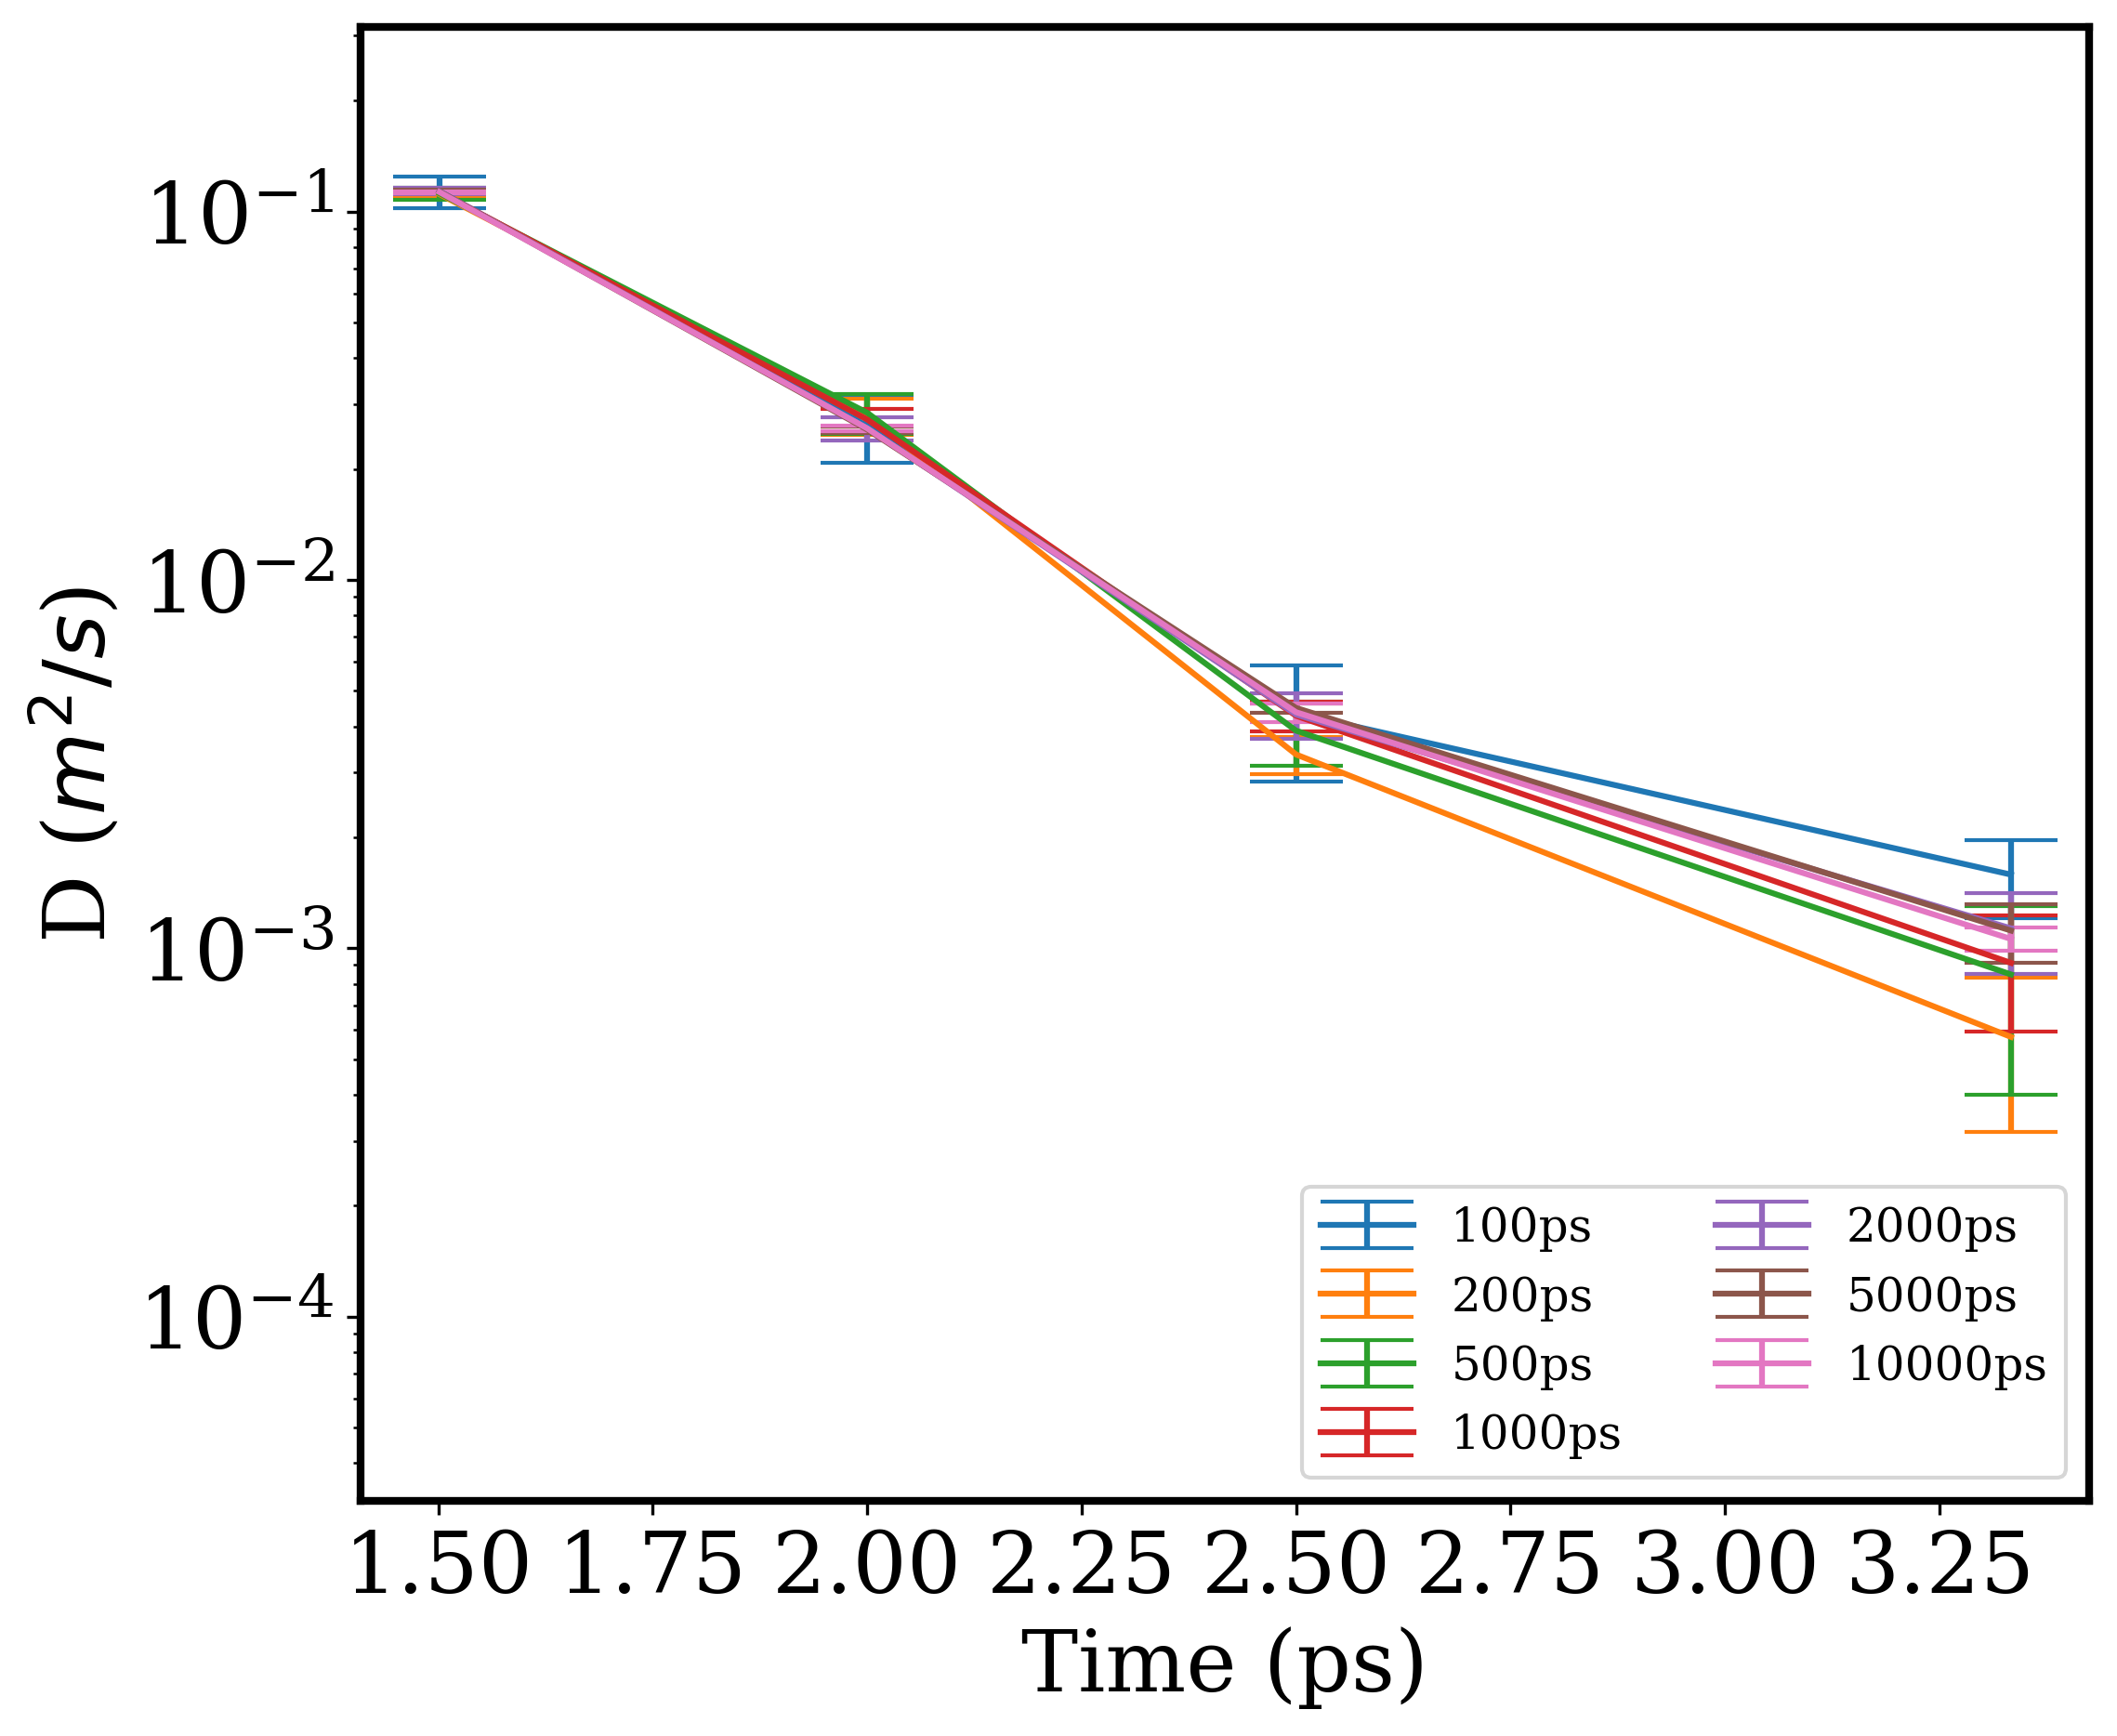

In [38]:
fig = plt.figure(figsize=[8, 7], dpi=300)

ax = fig.gca()
ax.spines["bottom"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

#plt.xscale('log')
plt.yscale('log')
for i, [sptime, part] in enumerate(splittime.groupby('time')):
#    for time, subpart in part.groupby('time'):
    part = part.sort_values('temperature')
    ax.errorbar(1000/part['temperature'], part['D'], part['D_std'], label=str(sptime)+'ps', 
                capsize=12,  markersize=12)
#    ax.scatter(part['time'], part['D'])
#    ax.fill_between(part['time'], 
#                    part['D']-part['D_std'], part['D']+part['D_std'], alpha=0.2)
    
plt.legend(fontsize=12, ncol=2, loc=4)
plt.ylim(10**(-4.5), 10**(-0.5),)
#plt.xlim(0.8, 3.5)
#plt.grid()
#plt.xscale('log')
#plt.xlim(0, 2000)
plt.xlabel('Time (ps)', fontsize=22)
plt.ylabel('D ($m^2/s$)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

## expand

In [39]:
path_msd = glob.glob('LiSiPS/expand/*/*/msd.npy')

In [40]:
rawexpand = pd.DataFrame([{
                    'temperature': int(path.split('/')[2].split('-')[0]),
                    'n_sample': path.split('/')[3],
                    'fix': path.split('/')[2].split('-')[1],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [41]:
rows = []
for temp, part in rawexpand.groupby('temperature'):
    for f, ppart in part.groupby('fix'):
        rows.append({
            'temperature': temp,
            'fix': f,
            'D': ppart['diffusivity'].values.mean(),
            'D_std': ppart['diffusivity'].values.std(),
        })
expand = pd.DataFrame(rows)

In [42]:
expand

,temperature,fix,D,D_std
0,500,expand,0.028752,0.003690
1,500,fix,0.022384,0.002680
2,666,expand,0.113902,0.003284
3,666,fix,0.093506,0.002123
4,800,expand,0.207615,0.005043
5,800,fix,0.161871,0.001910
6,1000,expand,0.389593,0.008653
7,1000,fix,0.294836,0.007996


In [43]:
fix = expand[expand['fix'] == 'fix']

In [44]:
k, b = np.polyfit(1000/fix['temperature'], np.log(fix['D']*10**-8), 1)

In [45]:
extra_t = np.linspace(1, 3.5, 6)

extra_d = np.e**(k * np.linspace(1, 3.5, 6) + b)

In [46]:
pbe = time.copy()

pbe = pbe.append(expand.loc[4])
pbe = pbe.append(expand.loc[6])

(array([1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

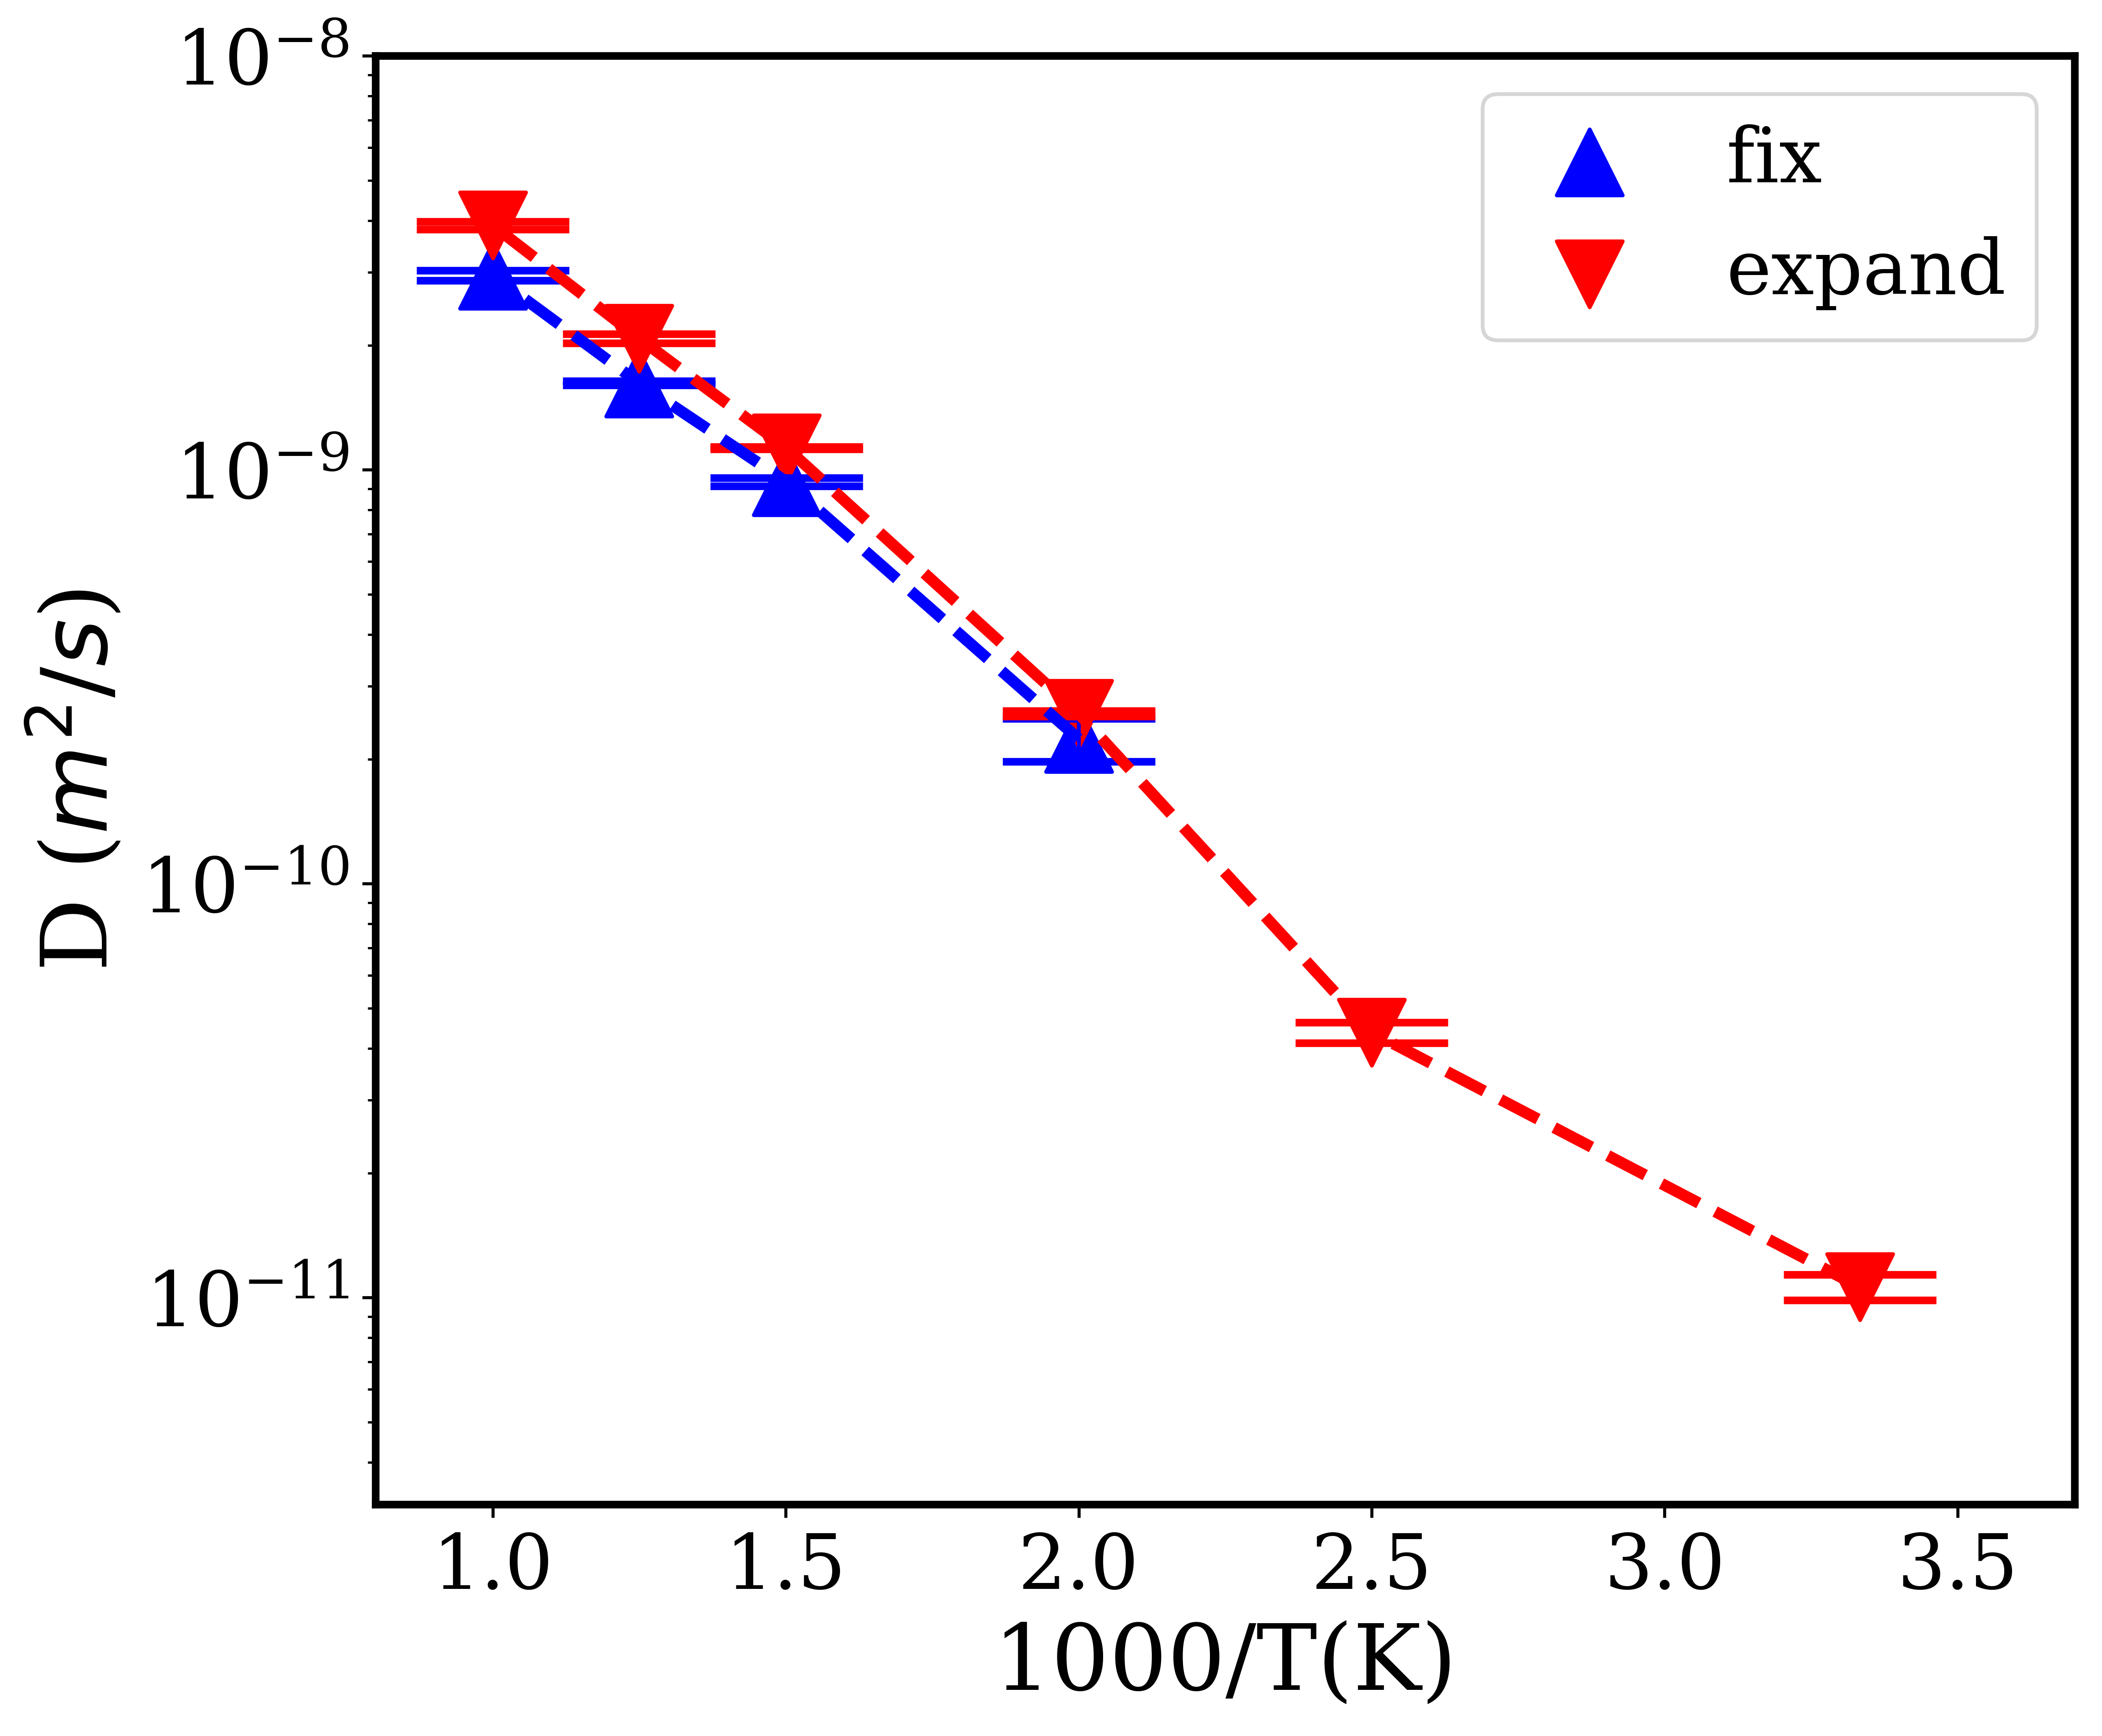

In [47]:
fig = plt.figure(figsize=[8, 7], dpi=600)
ax = fig.gca()
ax.spines["bottom"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

plt.scatter(1000/fix['temperature'], fix['D']*10**-8,  label='fix',
             marker='^', s=300, color='blue')
plt.scatter(1000/pbe['temperature'], pbe['D']*10**-8, label='expand', 
            marker='v', s=300, color='red')

plt.legend(fontsize=20)

#plt.plot(extra_t, extra_d, linestyle='dashed', linewidth=3, color='grey', alpha=0.6)

plt.errorbar(1000/fix['temperature'], fix['D']*10**-8, fix['D_std']*10**-8,
            linewidth=3, linestyle='dashed',capsize=20, capthick=2, elinewidth=1, 
             color='blue')
plt.errorbar(1000/pbe['temperature'], pbe['D']*10**-8, pbe['D_std']*10**-8,
             linewidth=3, linestyle='dashed',capsize=20, capthick=2, elinewidth=1,
            color='red')

plt.yscale('log')
plt.ylim(10**(-11.5), 1e-8,)
plt.xlim(0.8, 3.7)
#plt.grid(linestyle='dashed')
plt.xlabel('1000/T(K)', fontsize=24)
plt.ylabel('D ($m^2/s$)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## functional

In [48]:
path_msd = glob.glob('LiSiPS/pbesol/*/*/msd.npy')

In [49]:
rawpbesol = pd.DataFrame([{
                    'temperature': int(path.split('/')[2].split('-')[0]),
                    'n_sample': path.split('/')[3],
                    'fix': path.split('/')[2].split('-')[1],
                    'functional': path.split('/')[1],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [50]:
rows = []
for temp, part in rawpbesol.groupby('temperature'):
    rows.append({
        'temperature': temp,
        'fix': 'expand',
        'D': part['diffusivity'].values.mean(),
        'D_std': part['diffusivity'].values.std(),
    })
pbesol = pd.DataFrame(rows)

In [51]:
pbe = time.copy()

pbe = pbe.append(expand.loc[4])
pbe = pbe.append(expand.loc[6])

(array([1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

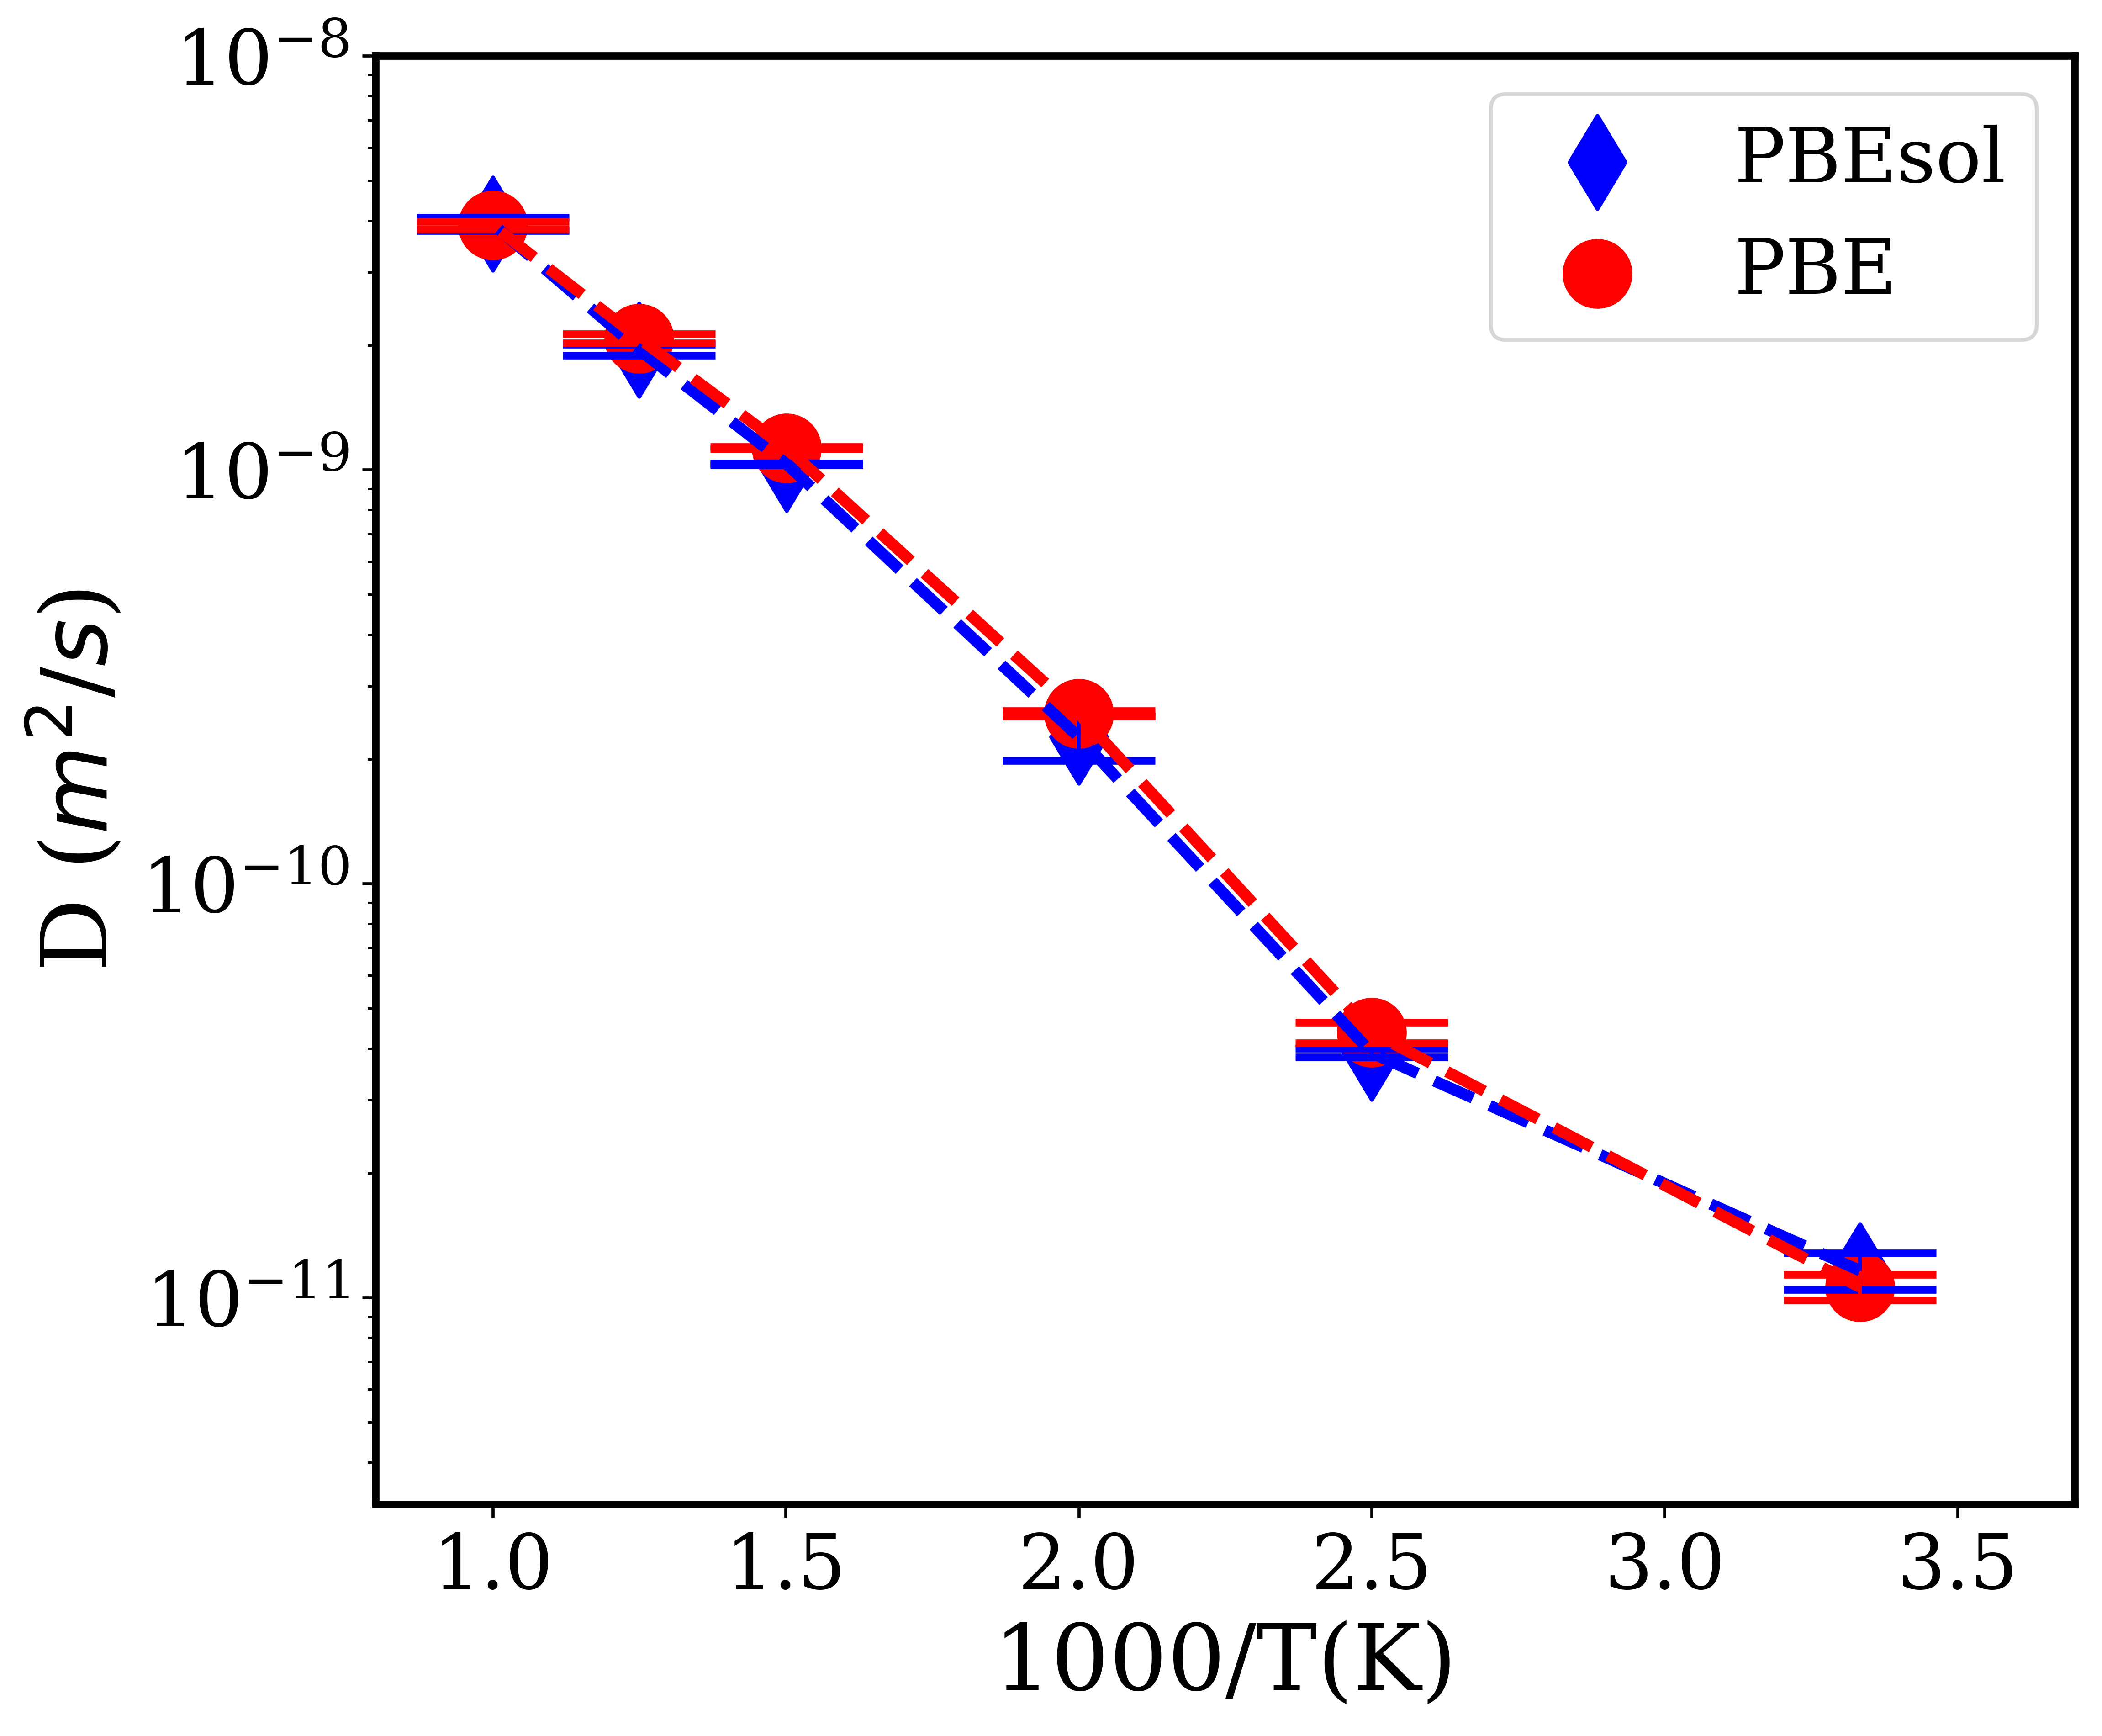

In [52]:
fig = plt.figure(figsize=[8, 7], dpi=600)
ax = fig.gca()
ax.spines["bottom"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

plt.scatter(1000/pbesol['temperature'], pbesol['D']*10**-8,  label='PBEsol',
             marker='d', s=300, color='blue')
plt.scatter(1000/pbe['temperature'], pbe['D']*10**-8, label='PBE', 
            marker='o', s=300, color='red')


plt.legend(fontsize=20)

plt.errorbar(1000/pbesol['temperature'], pbesol['D']*10**-8, pbesol['D_std']*10**-8,
            linewidth=3, linestyle='dashed', capsize=20, capthick=2, 
             elinewidth=1, color='blue')
plt.errorbar(1000/pbe['temperature'], pbe['D']*10**-8, pbe['D_std']*10**-8,
             linewidth=3, linestyle='dashed',capsize=20, capthick=2, 
             elinewidth=1, color='red')
#plt.errorbar(1000/disorder['temperature'], disorder['D'], disorder['D_std'], label='disorder')


plt.yscale('log')
plt.ylim(10**(-11.5), 1e-8,)
plt.xlim(0.8, 3.7)
#plt.grid()
plt.xlabel('1000/T(K)', fontsize=24)
plt.ylabel('D ($m^2/s$)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## disorder

In [53]:
path_msd = glob.glob('LiSiPS/disorder/*/*/msd.npy')

In [54]:
rawdisorder = pd.DataFrame([{'temperature': int(path.split('/')[2]),
                    'n_sample': path.split('/')[3],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [55]:
rows = []
for temp, part in rawdisorder.groupby('temperature'):
    rows.append({
        'temperature': temp,
        'D': part['diffusivity'].values.mean(),
        'D_std': part['diffusivity'].values.std(),
    })
disorder = pd.DataFrame(rows)

(array([1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

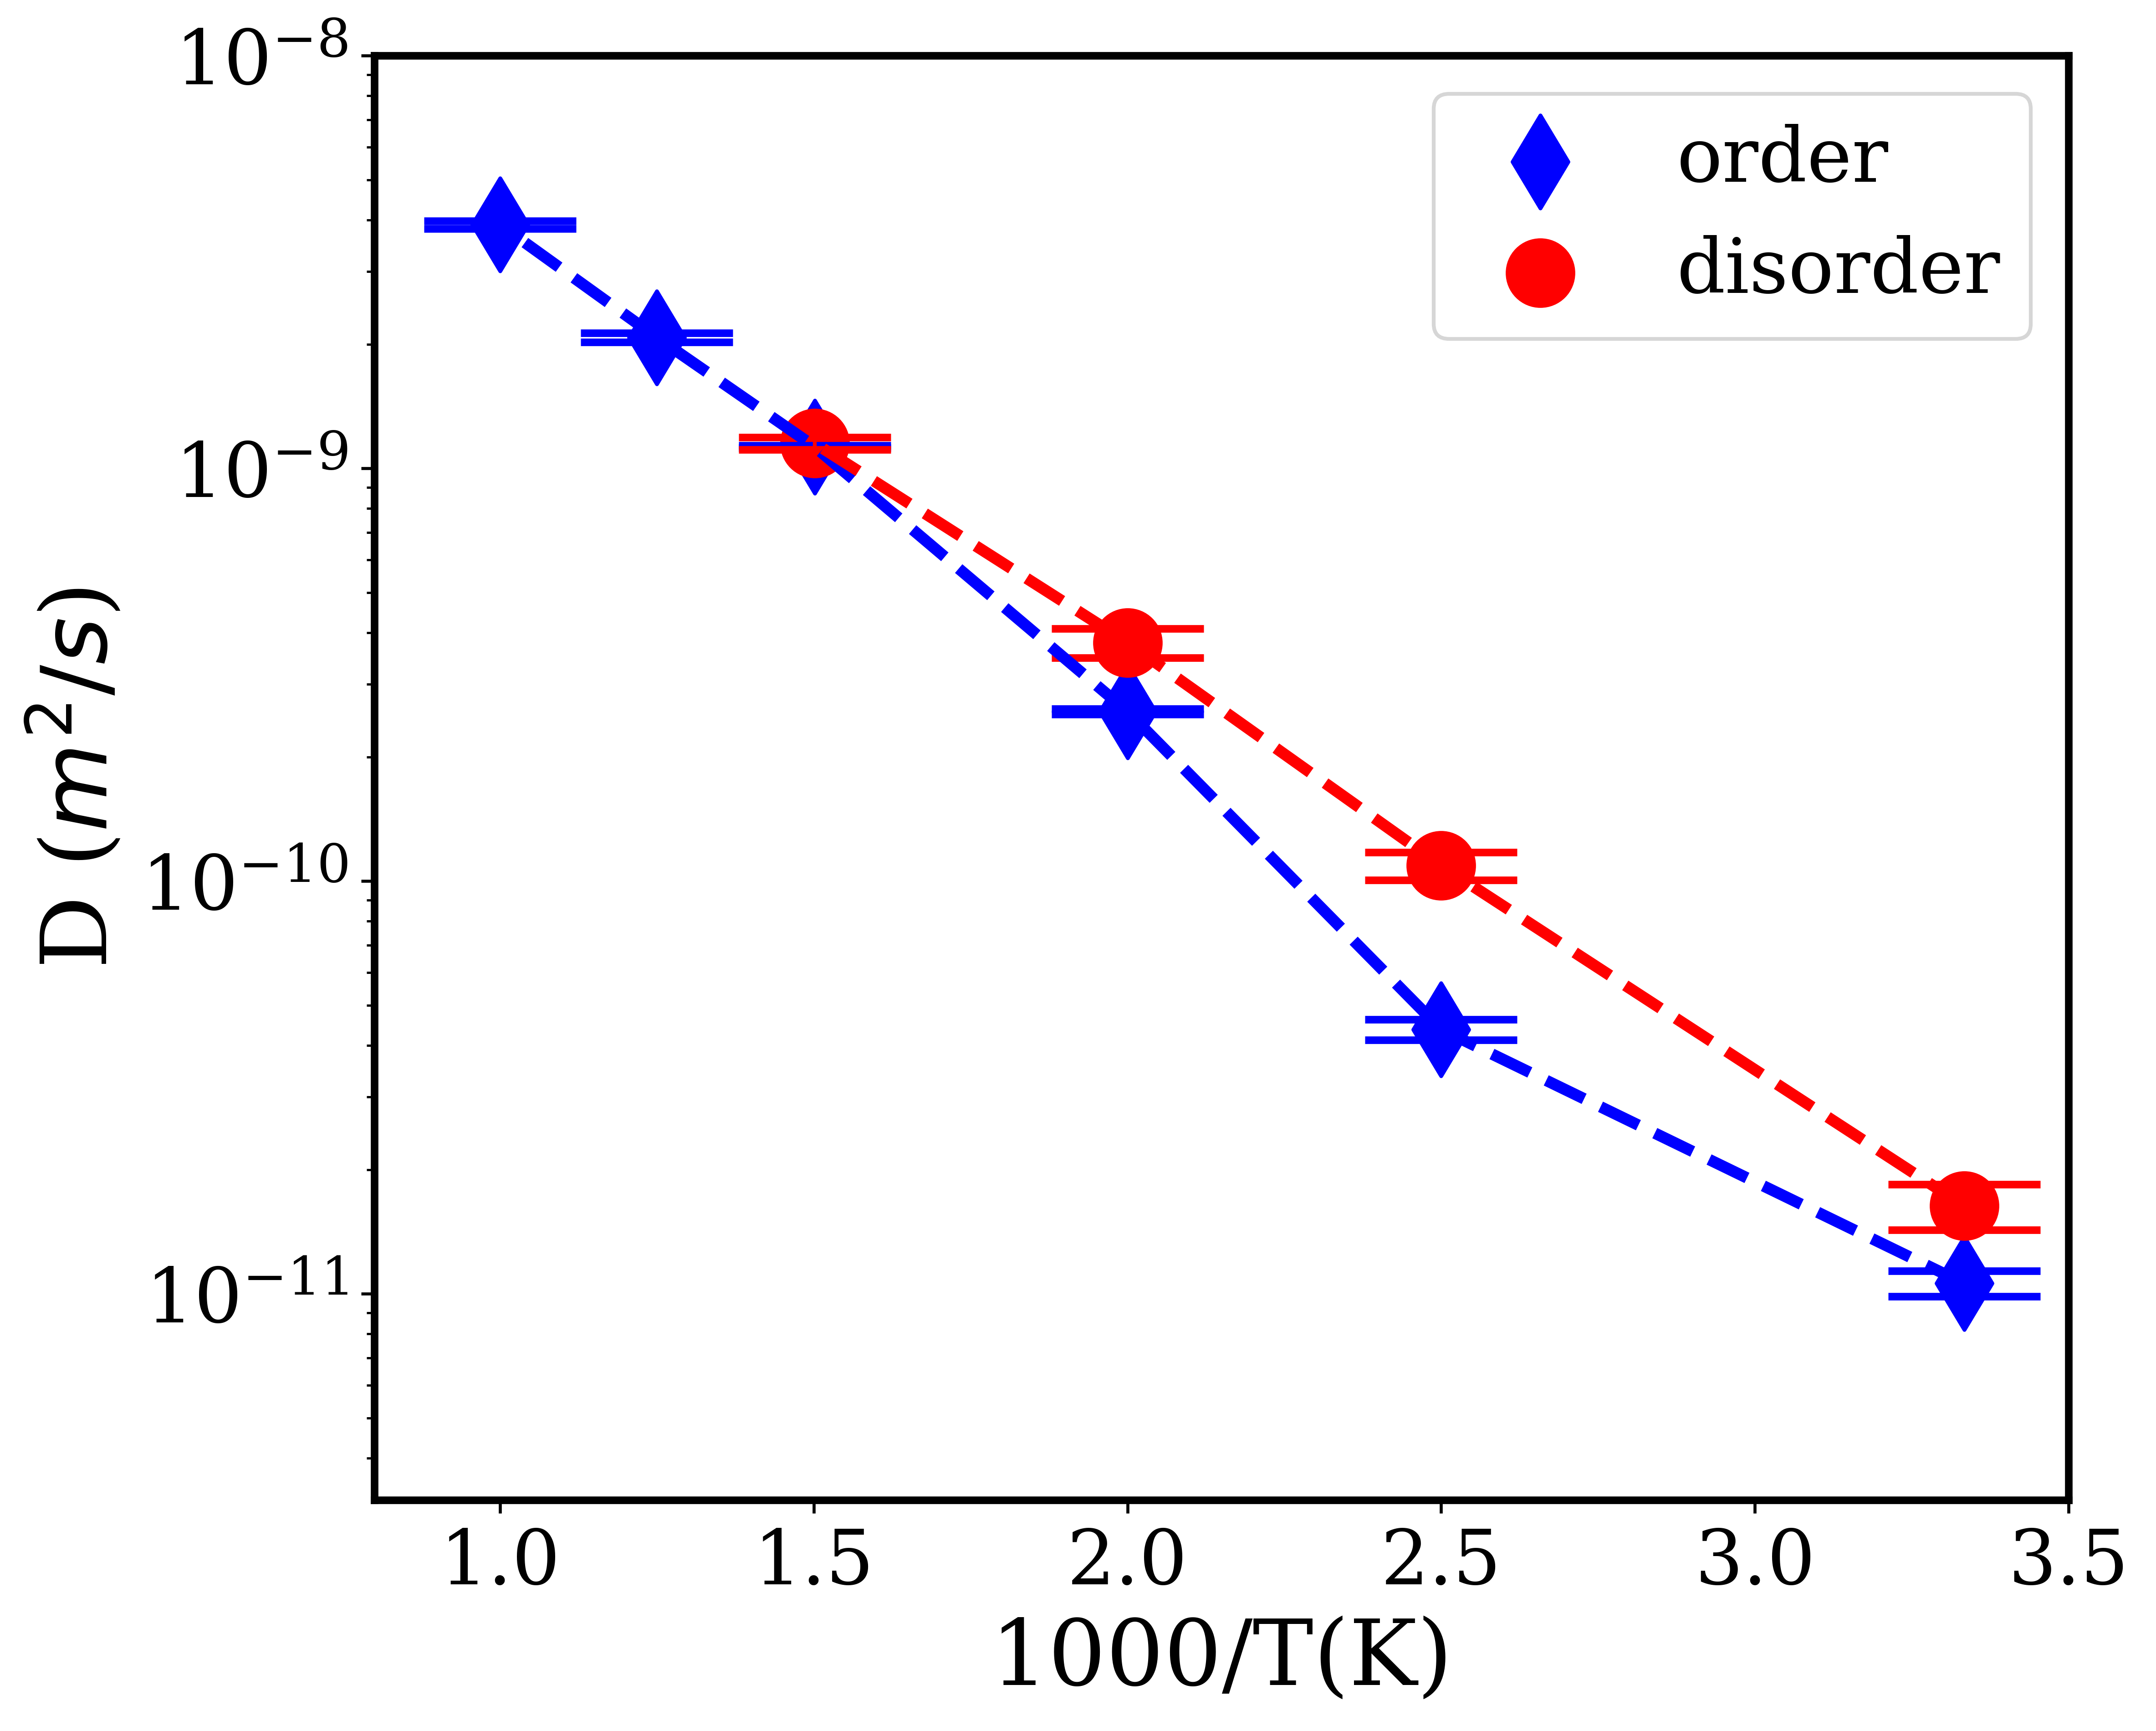

In [56]:
fig = plt.figure(figsize=[8, 7], dpi=600)
ax = fig.gca()
ax.spines["bottom"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

plt.scatter(1000/pbe['temperature'], pbe['D']*10**-8,  label='order',
             marker='d', s=300, color='blue')
plt.scatter(1000/disorder['temperature'], disorder['D']*10**-8, label='disorder', 
            marker='o', s=300, color='red')

plt.legend(fontsize=20)

plt.errorbar(1000/pbe['temperature'], pbe['D']*10**-8, pbe['D_std']*10**-8, 
             linewidth=3, linestyle='dashed', capsize=20, capthick=2, 
             elinewidth=1, color='blue')
plt.errorbar(1000/disorder['temperature'], disorder['D']*10**-8, disorder['D_std']*10**-8,
             linewidth=3, linestyle='dashed', capsize=20, capthick=2, 
             elinewidth=1, color='red')

plt.yscale('log')
plt.ylim(10**(-11.5), 1e-8,)
plt.xlim(0.8, 3.5)
#plt.grid()
plt.xlabel('1000/T(K)', fontsize=24)
plt.ylabel('D ($m^2/s$)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## ensemble

In [ ]:
path_msd = glob.glob('LiSiPS/ensemble/*/*/msd.npy')

In [ ]:
rawensemble = pd.DataFrame([{
                    'temperature': int(path.split('/')[2].split('-')[0]),
                    'n_sample': path.split('/')[3],
                    'fix': path.split('/')[2].split('-')[1],
                    'diffusivity': fit_msd(np.sum(np.load(path), axis=1))[0]/6 , } 
                   for path in path_msd])

In [ ]:
rows = []
for temp, part in rawensemble.groupby('temperature'):
    rows.append({
        'temperature': temp,
        'fix': f,
        'D': part['diffusivity'].values.mean(),
        'D_std': part['diffusivity'].values.std(),
    })
ensemble = pd.DataFrame(rows)

In [ ]:
plt.errorbar(1000/ensemble['temperature'], ensemble['D'], ensemble['D_std'], label='NVE')
plt.errorbar(1000/time['temperature'], time['D'], time['D_std'], label='NVT')
#plt.errorbar(1000/disorder['temperature'], disorder['D'], disorder['D_std'], label='disorder')
plt.yscale('log')
plt.legend()